In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["font.sans-serif"] = "SimHei" #解决中文乱码问题
import seaborn as sns
import random
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn.neighbors import KNeighborsRegressor

In [6]:
df_train = pd.read_csv(r'data_format1\train_format1.csv')
df_test = pd.read_csv(r'data_format1\test_format1.csv')
user_info = pd.read_csv(r'data_format1\user_info_format1.csv')
user_log = pd.read_csv(r'data_format1\user_log_format1.csv')
 
print(df_test.shape,df_train.shape)
print(user_info.shape,user_log.shape)

(261477, 3) (260864, 3)
(424170, 3) (54925330, 7)


In [7]:
#user_info 使用空值去替换
#user_info['age_range'].replace(0.0,np.nan,inplace=True)
#user_info['gender'].replace(2.0,np.nan,inplace=True)
#user_info.info()
user_info['age_range'] = user_info['age_range'].replace(0.0, np.nan)
user_info['gender'] = user_info['gender'].replace(2.0,np.nan)
user_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 424170 entries, 0 to 424169
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   user_id    424170 non-null  int64  
 1   age_range  329039 non-null  float64
 2   gender     407308 non-null  float64
dtypes: float64(2), int64(1)
memory usage: 9.7 MB


In [8]:
#user_info使用-1替换空值
#user_info['age_range'].replace(np.nan,-1,inplace=True)
#user_info['gender'].replace(np.nan,-1,inplace=True)
user_info['age_range'] = user_info['age_range'].replace(np.nan, -1)  
user_info['gender'] = user_info['gender'].replace(np.nan, -1)

Text(0.5, 1.0, '用户年龄分布')

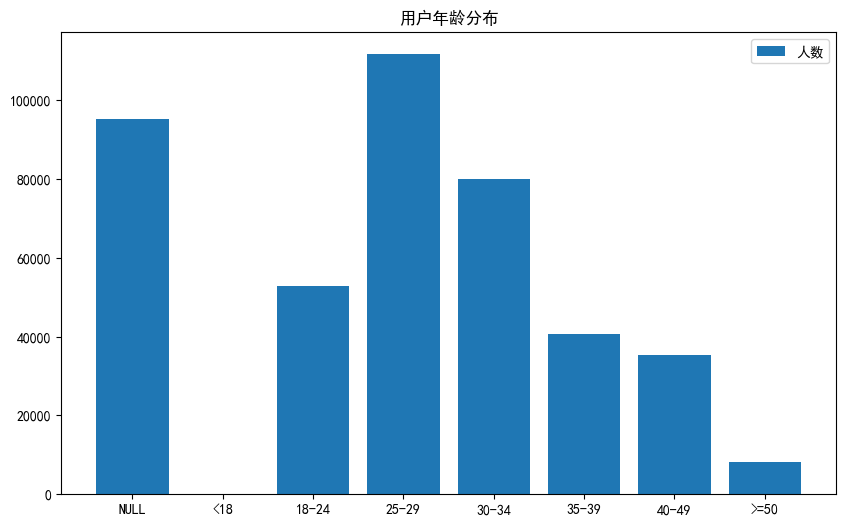

In [9]:
#年龄分布可视化
fig = plt.figure(figsize = (10,6))
x = np.array(["NULL","<18","18-24","25-29","30-34","35-39","40-49",">=50"])
y = np.array([user_info[user_info['age_range'] == -1]['age_range'].count(),
              user_info[user_info['age_range'] == 1]['age_range'].count(),
              user_info[user_info['age_range'] == 2]['age_range'].count(),
              user_info[user_info['age_range'] == 3]['age_range'].count(),
              user_info[user_info['age_range'] == 4]['age_range'].count(),
              user_info[user_info['age_range'] == 5]['age_range'].count(),
              user_info[user_info['age_range'] == 6]['age_range'].count(),
              user_info[user_info['age_range'] == 7]['age_range'].count()+
              user_info[user_info['age_range'] == 8]['age_range'].count()])
plt.bar(x,y,label='人数')
plt.legend()
plt.title('用户年龄分布')

Text(0.5, 1.0, '用户性别分布')

D:\software\python\lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) SimHei.
  func(*args, **kwargs)
D:\software\python\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) SimHei.
  fig.canvas.print_figure(bytes_io, **kw)


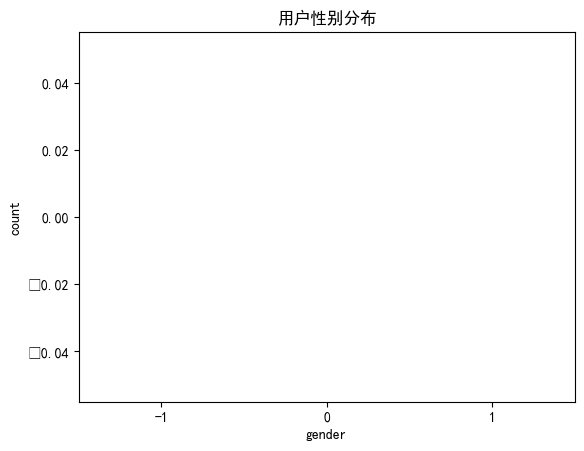

In [10]:
#用户性别分布可视化
sns.countplot(x = 'gender',order = [-1,0,1],data = user_info)
plt.title('用户性别分布')

Text(0.5, 1.0, '用户年龄—性别分布')

D:\software\python\lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) SimHei.
  func(*args, **kwargs)
D:\software\python\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) SimHei.
  fig.canvas.print_figure(bytes_io, **kw)


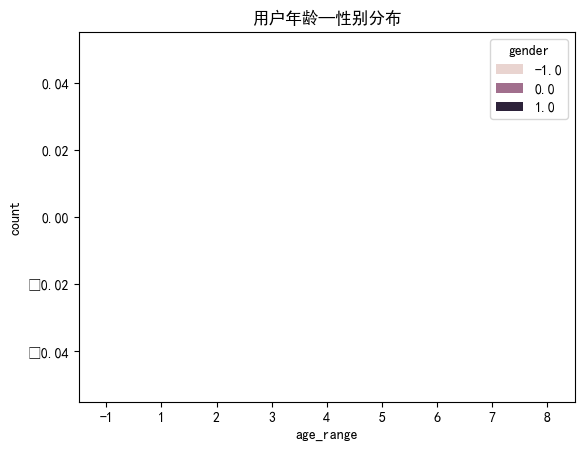

In [11]:
#用户年龄-性别分布
sns.countplot(x = 'age_range',order = [-1,1,2,3,4,5,6,7,8],hue = 'gender',data = user_info)
plt.title('用户年龄—性别分布')

In [12]:
#开始进行特征值合并
df_train = pd.merge(df_train,user_info,on="user_id",how="left")
 
total_logs_temp = user_log.groupby([user_log["user_id"],user_log["seller_id"]])["item_id"].count().reset_index()
 
total_logs_temp.rename(columns={"seller_id":"merchant_id","item_id":"total_item_id"},inplace=True)
 
df_train = pd.merge(df_train,total_logs_temp,on=["user_id","merchant_id"],how="left")
 
unique_item_id = user_log.groupby(["user_id","seller_id","item_id"]).count().reset_index()[["user_id","seller_id","item_id"]]
 
unique_item_id_cnt = unique_item_id.groupby(["user_id","seller_id"]).count().reset_index()
 
unique_item_id_cnt.rename(columns={"seller_id":"merchant_id","item_id":"unique_item_id"},inplace=True)
 
df_train = pd.merge(df_train, unique_item_id_cnt, on=["user_id", "merchant_id"], how="left")
 
cat_id_temp = user_log.groupby(["user_id", "seller_id", "cat_id"]).count().reset_index()[["user_id", "seller_id", "cat_id"]]
 
cat_id_temp_cnt = cat_id_temp.groupby(["user_id", "seller_id"]).count().reset_index()
 
cat_id_temp_cnt.rename(columns={"seller_id":"merchant_id","cat_id":"total_cat_id"},inplace=True)
 
df_train = pd.merge(df_train, cat_id_temp_cnt, on=["user_id", "merchant_id"], how="left")
 
time_temp = user_log.groupby(["user_id", "seller_id", "time_stamp"]).count().reset_index()[["user_id", "seller_id", "time_stamp"]]
 
time_temp_cnt = time_temp.groupby(["user_id", "seller_id"]).count().reset_index()
 
time_temp_cnt.rename(columns={"seller_id":"merchant_id","time_stamp":"total_time_temp"},inplace=True)
 
df_train = pd.merge(df_train, time_temp_cnt, on=["user_id", "merchant_id"], how="left")
 
click_temp = user_log.groupby(["user_id", "seller_id", "action_type"])["item_id"].count().reset_index()
 
click_temp.rename(columns={"seller_id":"merchant_id","item_id":"times"},inplace=True)
 
click_temp["clicks"] = click_temp["action_type"] == 0
 
click_temp["clicks"] = click_temp["clicks"] * click_temp["times"]
 
click_temp["shopping_cart"] = click_temp["action_type"] == 1
click_temp["shopping_cart"] = click_temp["shopping_cart"] * click_temp["times"]
 
click_temp["purchases"] = click_temp["action_type"] == 2
click_temp["purchases"] = click_temp["purchases"] * click_temp["times"]
 
click_temp["favourites"] = click_temp["action_type"] == 3
click_temp["favourites"] = click_temp["favourites"] * click_temp["times"]
 
four_features = click_temp.groupby(["user_id", "merchant_id"]).sum().reset_index()
 
#删除相关列
four_features = four_features.drop(["action_type", "times"], axis=1)
 
#合并
df_train = pd.merge(df_train, four_features, on=["user_id", "merchant_id"], how="left")
 
#缺失值向前填充
df_train = df_train.ffill()

In [13]:
#将构建好的特征保存
df_train.to_csv("df_train.csv",index = None)

In [14]:
#测试数据特征值合并
df_test = pd.merge(df_test,user_info,on="user_id",how="left")
 
total_logs_temp = user_log.groupby([user_log["user_id"],user_log["seller_id"]])["item_id"].count().reset_index()
 
total_logs_temp.rename(columns={"seller_id":"merchant_id","item_id":"total_item_id"},inplace=True)
 
df_test = pd.merge(df_test,total_logs_temp,on=["user_id","merchant_id"],how="left")
 
unique_item_id = user_log.groupby(["user_id","seller_id","item_id"]).count().reset_index()[["user_id","seller_id","item_id"]]
 
unique_item_id_cnt = unique_item_id.groupby(["user_id","seller_id"]).count().reset_index()
 
unique_item_id_cnt.rename(columns={"seller_id":"merchant_id","item_id":"unique_item_id"},inplace=True)
 
df_test = pd.merge(df_test, unique_item_id_cnt, on=["user_id", "merchant_id"], how="left")
 
cat_id_temp = user_log.groupby(["user_id", "seller_id", "cat_id"]).count().reset_index()[["user_id", "seller_id", "cat_id"]]
 
cat_id_temp_cnt = cat_id_temp.groupby(["user_id", "seller_id"]).count().reset_index()
 
cat_id_temp_cnt.rename(columns={"seller_id":"merchant_id","cat_id":"total_cat_id"},inplace=True)
 
df_test = pd.merge(df_test, cat_id_temp_cnt, on=["user_id", "merchant_id"], how="left")
 
time_temp = user_log.groupby(["user_id", "seller_id", "time_stamp"]).count().reset_index()[["user_id", "seller_id", "time_stamp"]]
 
time_temp_cnt = time_temp.groupby(["user_id", "seller_id"]).count().reset_index()
 
time_temp_cnt.rename(columns={"seller_id":"merchant_id","time_stamp":"total_time_temp"},inplace=True)
 
df_test = pd.merge(df_test, time_temp_cnt, on=["user_id", "merchant_id"], how="left")
 
click_temp = user_log.groupby(["user_id", "seller_id", "action_type"])["item_id"].count().reset_index()
click_temp.rename(columns={"seller_id":"merchant_id","item_id":"times"},inplace=True)
 
click_temp["clicks"] = click_temp["action_type"] == 0
 
click_temp["clicks"] = click_temp["clicks"] * click_temp["times"]
 
click_temp["shopping_cart"] = click_temp["action_type"] == 1
click_temp["shopping_cart"] = click_temp["shopping_cart"] * click_temp["times"]
 
click_temp["purchases"] = click_temp["action_type"] == 2
click_temp["purchases"] = click_temp["purchases"] * click_temp["times"]
 
click_temp["favourites"] = click_temp["action_type"] == 3
click_temp["favourites"] = click_temp["favourites"] * click_temp["times"]
 
four_features = click_temp.groupby(["user_id", "merchant_id"]).sum().reset_index()
 
#删除相关列
four_features = four_features.drop(["action_type", "times"], axis=1)
 
#合并
df_test = pd.merge(df_test, four_features, on=["user_id", "merchant_id"], how="left")
 
#缺失值向前填充
df_test = df_test.fillna(method="ffill")


C:\Users\Betty\AppData\Local\Temp\ipykernel_27216\3354618912.py:59: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_test = df_test.fillna(method="ffill")


In [15]:
df_test

,user_id,merchant_id,prob,age_range,gender,total_item_id,unique_item_id,total_cat_id,total_time_temp,clicks,shopping_cart,purchases,favourites
0,163968,4605,NaN,-1.0,0.0,2,1,1,1,1,0,1,0
1,360576,1581,NaN,2.0,-1.0,10,9,4,1,5,0,5,0
2,98688,1964,NaN,6.0,0.0,6,1,1,1,5,0,1,0
3,98688,3645,NaN,6.0,0.0,11,1,1,1,10,0,1,0
4,295296,3361,NaN,2.0,1.0,50,8,4,5,47,0,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
261472,228479,3111,NaN,6.0,0.0,5,2,1,2,4,0,1,0
261473,97919,2341,NaN,8.0,1.0,2,1,1,1,1,0,1,0
261474,97919,3971,NaN,8.0,1.0,16,5,2,3,12,0,4,0
261475,32639,3536,NaN,-1.0,0.0,3,2,1,1,2,0,1,0


In [16]:
#测试数据预处理
# y = df_train["label"]
x = df_test.drop(["user_id", "merchant_id", "prob"], axis=1)
# X['age_range'].replace(-1,3,inplace=True)
# X['gender'].replace(-1,0,inplace=True)
x

,age_range,gender,total_item_id,unique_item_id,total_cat_id,total_time_temp,clicks,shopping_cart,purchases,favourites
0,-1.0,0.0,2,1,1,1,1,0,1,0
1,2.0,-1.0,10,9,4,1,5,0,5,0
2,6.0,0.0,6,1,1,1,5,0,1,0
3,6.0,0.0,11,1,1,1,10,0,1,0
4,2.0,1.0,50,8,4,5,47,0,1,2
...,...,...,...,...,...,...,...,...,...,...
261472,6.0,0.0,5,2,1,2,4,0,1,0
261473,8.0,1.0,2,1,1,1,1,0,1,0
261474,8.0,1.0,16,5,2,3,12,0,4,0
261475,-1.0,0.0,3,2,1,1,2,0,1,0


In [17]:
#将构建好的特征保存
x.to_csv("test_data.csv",index = None)

In [18]:
#建模预处理
y = df_train['label']
x = df_train.drop(["user_id","merchant_id","label"],axis = 1)
x.head(10)

,age_range,gender,total_item_id,unique_item_id,total_cat_id,total_time_temp,clicks,shopping_cart,purchases,favourites
0,6.0,0.0,39,20,6,9,36,0,1,2
1,6.0,0.0,14,1,1,3,13,0,1,0
2,6.0,0.0,18,2,1,2,12,0,6,0
3,6.0,0.0,2,1,1,1,1,0,1,0
4,-1.0,0.0,8,1,1,3,7,0,1,0
5,4.0,1.0,1,1,1,1,0,0,1,0
6,5.0,0.0,3,2,1,1,2,0,1,0
7,5.0,0.0,83,48,15,3,78,0,5,0
8,5.0,0.0,7,4,1,1,6,0,1,0
9,4.0,1.0,4,1,1,2,2,0,1,1


In [19]:
#分割数据
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.2,random_state = 8)

In [20]:
#读取数据
#df_train = pd.read_csv(r"df_train.csv")
#加载最终测试数据
test_data = pd.read_csv(r"test_data.csv")
test_data

,age_range,gender,total_item_id,unique_item_id,total_cat_id,total_time_temp,clicks,shopping_cart,purchases,favourites
0,-1.0,0.0,2,1,1,1,1,0,1,0
1,2.0,-1.0,10,9,4,1,5,0,5,0
2,6.0,0.0,6,1,1,1,5,0,1,0
3,6.0,0.0,11,1,1,1,10,0,1,0
4,2.0,1.0,50,8,4,5,47,0,1,2
...,...,...,...,...,...,...,...,...,...,...
261472,6.0,0.0,5,2,1,2,4,0,1,0
261473,8.0,1.0,2,1,1,1,1,0,1,0
261474,8.0,1.0,16,5,2,3,12,0,4,0
261475,-1.0,0.0,3,2,1,1,2,0,1,0


In [21]:
#模型构建

In [22]:
#建模预处理
#y = df_test['prob']
#x = df_test.drop(["user_id","merchant_id","prob"],axis = 1)
#x.head(10)
#分割数据
#x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.2,random_state = 10)

In [23]:
#logistic回归
logit = LogisticRegression(solver = 'liblinear')
logit.fit(x_test,y_test)
predict = logit.predict(x_test)
predict_proba = logit.predict_proba(x_test)
print(predict.shape)
print(predict[0:20]) #打印前20个预测结果

print(predict_proba[:]) #打印所有预测结果
score = accuracy_score(y_test,predict)
score #打印准确率

(52173,)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[[0.9250506  0.0749494 ]
 [0.95497875 0.04502125]
 [0.94017273 0.05982727]
 ...
 [0.94310792 0.05689208]
 [0.88450883 0.11549117]
 [0.95296091 0.04703909]]


0.9392214363751366

In [24]:
#逻辑回归最终结果获取
Logit_Ans_Predict_proba = logit.predict_proba(test_data)
df_test['prob']=Logit_Ans_Predict_proba[:,1]
#最终答案保存
df_test.to_csv("Logit_Ans.csv",index=None)

In [25]:
#决策树
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(max_depth=4,random_state=0) 
tree.fit(x_train, y_train)
Predict_proba = tree.predict_proba(x_test)
print(Predict_proba[:])
print("Accuracy on training set: {:.3f}".format(tree.score(x_train, y_train)))
print("Accuracy on test set: {:.3f}".format(tree.score(x_test, y_test)))

[[0.89765569 0.10234431]
 [0.9609094  0.0390906 ]
 [0.93901148 0.06098852]
 ...
 [0.92812445 0.07187555]
 [0.89765569 0.10234431]
 [0.9609094  0.0390906 ]]
Accuracy on training set: 0.939
Accuracy on test set: 0.939


In [26]:
#决策树最终结果获取
Tree_Ans_Predict_proba = tree.predict_proba(test_data)
df_test['prob']=Tree_Ans_Predict_proba[:,1]
#最终答案保存
df_test.to_csv("Tree_Ans.csv",index=None)

In [27]:
#随机森林
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=100,random_state=90,max_depth=8)
rfc = rfc.fit(x_train, y_train)
Predict_proba = rfc.predict_proba(x_test)
print(Predict_proba[:])
print("Accuracy on training set: {:.3f}".format(rfc.score(x_train, y_train))) 
print("Accuracy on test set: {:.3f}".format(rfc.score(x_test, y_test)))

[[0.90345203 0.09654797]
 [0.96242055 0.03757945]
 [0.92398178 0.07601822]
 ...
 [0.91943483 0.08056517]
 [0.86844252 0.13155748]
 [0.9607207  0.0392793 ]]
Accuracy on training set: 0.939
Accuracy on test set: 0.939


In [28]:
#随机森林最终结果获取
RFC_Ans_Predict_proba = rfc.predict_proba(test_data)
df_test['prob']=RFC_Ans_Predict_proba[:,1]
#最终答案保存
df_test.to_csv("RFC_Ans.csv",index=None)